In [1]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Config: 
    def __init__(self,atoms,pH,pOH,proton_count,conjugate_base_count,timestep,totalEnergy,pressure,temperature,cell):
        self.atoms=atoms
        self.pH=pH
        self.pOH=pOH
        self.proton_count=proton_count
        self.conjugate_base_count=conjugate_base_count
        self.timestep=timestep
        self.totalEnergy=totalEnergy
        self.pressure=pressure
        self.temperature=temperature
        if cell==None:
            self.cell=cell
        else:
            self.cell=[float(i) for i in cell]

def calc_dist(pivot,i_vector,boxl):
        direction=pivot-i_vector
        direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
        direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
        direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
        dist=np.linalg.norm(direction)
        return dist
    
def atomicToAngstrom(d):
    return d*0.5291772106

def angstromToAtomic(d):
    return d/0.5291772106

In [3]:
class Atom:
    def __init__(self,x,y,z,element,charge,notused,fx,fy,fz,hydrogens,oxygen):
        self.x=float(x)
        self.y=float(y)
        self.z=float(z)
        self.element=str(element)
        self.charge=float(charge)
        self.notused=int(float(notused))
        self.fx=float(fx)
        self.fy=float(fy)
        self.fz=float(fz)
        self.hydrogens=hydrogens
        self.oxygen=oxygen
    
    @classmethod
    def from_lammps(cls, element, x, y, z,notused):
        obj = object.__new__(cls)
        obj.x = float(x)
        obj.y = float(y)
        obj.z = float(z)
        obj.element = str(element)
        obj.notused = notused
        obj.hydrogens=[]
        obj.oxygen=None
        return obj

    
    def scan_vicinity(self,config,cutoff,boxl):
        pivot=np.array([self.x,self.y,self.z])
        config=np.array(config)
        for ind,i in enumerate(config):
            #print(str(ind)+" element= "+i.element,type(i.notused))
            if(i.element=="O"):
                i_vector=np.array([i.x,i.y,i.z])
                #print("O at"+str(ind))
                direction=pivot-i_vector
                direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
                direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
                direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
                dist=np.linalg.norm(direction)
                if(dist<cutoff):
                    #can set notused = 1 here. Need to ponder
                    
                    return False
        return True
    
    def distance(self,atom,boxl):
        pivot = np.array([self.x,self.y,self.z])
        i_vector = np.array([atom.x,atom.y,atom.z])
        direction=pivot-i_vector
        direction[0]=direction[0]-(boxl*np.round(direction[0]/boxl))
        direction[1]=direction[1]-(boxl*np.round(direction[1]/boxl))
        direction[2]=direction[2]-(boxl*np.round(direction[2]/boxl))
        dist=np.linalg.norm(direction)
        return dist
    
    def scan_H_OH(self,config,cutoff,boxl,dynamic_cell):
        config=np.array(config)
        for ind,i in enumerate(config):
            if(i.element=="H"):
                i_vector=np.array([i.x,i.y,i.z])
                dist=self.distance(i,boxl)
                if(dist<cutoff):
                    if(len(self.hydrogens)<2 and (not (i,dist) in self.hydrogens)):
                        if(i.oxygen == None or i.distance(i.oxygen,boxl)>dist):
                            if(i.oxygen!=None): #remove hydrogen from oxygen
                                for hydrogen in i.oxygen.hydrogens:
                                    if(hydrogen[0] == i):
                                        i.oxygen.hydrogens.remove(hydrogen)
                            self.hydrogens.append((i,dist))
                            self.hydrogens.sort(key=lambda tup: tup[1])
                            i.oxygen=self
                    elif(dist<self.hydrogens[-1][1] and (not (i,dist) in self.hydrogens)):
                        if(i.oxygen == None or i.distance(i.oxygen,boxl)>dist):
                            if(i.oxygen!=None): #remove hydrogen from oxygen
                                for hydrogen in i.oxygen.hydrogens:
                                    if(hydrogen[0] == i):
                                        i.oxygen.hydrogens.remove(hydrogen)
                            print("dist = %s and farthest hydrogen %s" %(dist, self.hydrogens[-1][1]))
                            self.hydrogens[-1][0].oxygen=None
                            self.hydrogens.pop()
                            self.hydrogens.append((i,dist))
                            self.hydrogens.sort(key=lambda tup: tup[1])
                            i.oxygen=self

                    else:
                        #print("RAN INTO ERROR:",i,i.hydrogens)
                        pass         

In [4]:
def parse(f_name):
    config=[]
    with open(f_name,'r') as f:
        temp=[]
        for i in f.readlines():
            i=str(i)
            #print(i)
            if("begin" in i):
                temp=[]
            elif("end" in i):
                config.append(Config(temp,None,None,None,None))
                break # need to remove for a whole file
            elif(i.startswith("atom")):
                a=i.split()
                temp.append(Atom(a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9]))
    return config                  

In [5]:
def parse_lammps_output(f_name):
    atoms=['O','H']
    config=[]
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("ITEM: TIMESTEP" in i):
                if(ind>0):
                    config.append(Config(temp,None,None,None,None))
                temp=[]
            elif(any(i.startswith(a) for a in atoms)):
                a=i.split()
                #print(a)
                temp.append(Atom.from_lammps(a[0],a[1],a[2],a[3],0))
    return config


In [6]:
def check_if_number(s):
    try:
        if(float(s).is_integer()):
            return True
        else:
            False
    except:
        return False

In [7]:
def parse_xyz_output(f_name,auto_timestep,dynamic_cell):
    if(auto_timestep):
        print("Using auto timestep assignment in order")
    if(dynamic_cell):
        print("Using dynamic cell constraints from file [x,-,-,-,y,-,-,-,z]")
    atoms=['H','O']
    config=[]
    element='X'
    timestep=-1
    flag=False
    cell=None
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("Atoms. Timestep:" in i ) or ("Lattice" in i):
                if(flag):
                    config.append(Config(temp,None,None,None,None,timestep,None,None,None,cell))
                    a=i.split(":")
                    if(not auto_timestep):
                        timestep=a[-1].strip()
                    else:
                        timestep+=1
                else:
                    if(not auto_timestep):
                        a=i.split(":")
                        timestep=a[-1].strip()
                    else:
                        timestep+=1
                # calculate dynamic cell 
                if(dynamic_cell):
                    a=i.split("=")
                    tempcell=a[1].strip(" Properties").strip("\"").split()
                    cell=[tempcell[0],tempcell[4],tempcell[8]]
                else:
                    pass
                        
                temp=[]
            elif((any(i.startswith(atom) for atom in atoms)) and (not check_if_number(i))):
                flag=True
                a=i.split()
                # Since elements are not marked with number here, need to assign element manually, hence passing the element
                if(a[0]==atoms[0]):
                    element="H"
                elif(a[0]==atoms[1]):
                    element="O"
                temp.append(Atom.from_lammps(element,a[1],a[2],a[3],0))
        config.append(Config(temp,None,None,None,None,timestep,None,None,None,cell))
    return config

In [8]:
def parse_xyz_output_dynamic_cell(f_name,auto_timestep):
    if(auto_timestep):
        print("Using auto timestep assignment in order")
    atoms=['H','O']
    config=[]
    element='X'
    timestep=-1
    flag=False
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("Atoms. Timestep:" in i ) or ("Lattice" in i):
                if(flag):
                    config.append(Config(temp,None,None,None,None,timestep,None,None,None))
                    a=i.split(":")
                    if(not auto_timestep):
                        timestep=a[-1].strip()
                    else:
                        timestep+=1
                else:
                    if(not auto_timestep):
                        a=i.split(":")
                        timestep=a[-1].strip()
                    else:
                        timestep+=1
                        
                temp=[]
            elif((any(i.startswith(atom) for atom in atoms)) and (not check_if_number(i))):
                flag=True
                a=i.split()
                # Since elements are not marked with number here, need to assign element manually, hence passing the element
                if(a[0]==atoms[0]):
                    element="H"
                elif(a[0]==atoms[1]):
                    element="O"
                temp.append(Atom.from_lammps(element,a[1],a[2],a[3],0))
        config.append(Config(temp,None,None,None,None,timestep,None,None,None))
    return config

In [9]:
def parse_biased_xyz(f_name):
    atoms=['O','H']
    config=[]
    element='X'
    timestep=-1
    flag=False
    with open(f_name,'r') as f:
        temp=[]
        for ind,i in enumerate(f.readlines()):
            i=str(i)
            if("Atoms. Timestep:" in i ):
                
                if(flag):
                    config.append(Config(temp,None,None,None,None,timestep,None,None,None))
                    a=i.split(":")
                    timestep=a[-1].strip()
                else:
                    a=i.split(":")
                    timestep=a[-1].strip()
                temp=[]
            elif((any(i.startswith(atom) for atom in atoms)) and (not check_if_number(i))):
                flag=True
                a=i.split()
                # Since elements are not marked with number here, need to assign element manually, hence passing the element
                if(a[0]==atoms[0]):
                    element="H"
                elif(a[0]==atoms[1]):
                    element="O"
                temp.append(Atom.from_lammps(element,a[1],a[2],a[3],0))
        config.append(Config(temp,None,None,None,None,timestep,None,None,None))
    return config

In [10]:
def pH(proton_count,boxl,Na):
    print("Proton Count = "+str(proton_count))
    n=proton_count/Na
    vol=1000*(boxl**3)
    #Molarity=n/vol
    #print("molarity=",Molarity)
    return -1*(np.log10(n)-np.log10(vol))

In [11]:
from sys import argv as a
import numpy as np
import matplotlib.pyplot as plt
import json

# Parse File

In [12]:
#config=parse("../training-set/input.data")
configs=parse_xyz_output("./data/trajectory_wrapped.xyz",True,True)
# configs=parse_biased_xyz("./data/out_unbiased5.xyz")
#config=parse_lammps_output("./out6.lammpstrj")


Using auto timestep assignment in order
Using dynamic cell constraints from file [x,-,-,-,y,-,-,-,z]


In [13]:
config=configs[::10]
print("config size",np.shape(config))
print(config[0].cell)
protons=[]

config size (160,)
[23.46511, 23.46511, 23.46511]


# Set Constants

In [14]:
cutoff=3 #needs to be atomic units since the coordinates are in atomic units
boxl_atomic=23.46511  #atomic
Na=6.0221409e+23
dynamic_cell=True

# Proton Count

In [15]:
for ind,j in enumerate(config):
    print(j.timestep)
    proton_count=0
    oh_count=0
    h2o_count=0
    for ind2,i in enumerate(j.atoms):
        if(dynamic_cell):
            boxl_atomic=j.cell[0]
        if(i.element=="O"):
            i.scan_H_OH(j.atoms,cutoff,boxl_atomic,True)
    for ind2,i in enumerate(j.atoms):
        if(i.element=="H"): 
            if(i.oxygen==None):
                proton_count+=1
        elif(i.element=="O" and len(i.hydrogens)==1):
            oh_count+=1
        elif(i.element=="O" and len(i.hydrogens)==2):
            h2o_count+=1
        #else:
        #    print("something happened here",i,json.dumps(i.__dict__))
    j.proton_count=proton_count
    j.conjugate_base_count=oh_count
    total=proton_count+2*oh_count+3*h2o_count
    protons.append((proton_count,oh_count,h2o_count,total))

0
10
dist = 1.8490714640978574 and farthest hydrogen 2.0430678002758493
20
30
40
50
dist = 1.9539276721772483 and farthest hydrogen 2.0114006579744377
60
70
80
dist = 2.05686611820021 and farthest hydrogen 2.096308276971687
dist = 1.970630597270832 and farthest hydrogen 2.0484770637964216
90
100
dist = 2.045050093518736 and farthest hydrogen 2.4514417529039934
dist = 1.882269313886829 and farthest hydrogen 1.980724965662825
110
dist = 1.7629879484556896 and farthest hydrogen 1.7937079973061392
120
130
140
dist = 1.8412802991397053 and farthest hydrogen 1.9458629345357288
150
dist = 1.809580628211961 and farthest hydrogen 1.968104179153128
dist = 1.8476636436321425 and farthest hydrogen 2.2815437065504582
160
170
180
190
200
dist = 1.8143516283785788 and farthest hydrogen 1.9710979685606695
210
dist = 1.8486037261944483 and farthest hydrogen 1.9315966062560797
220
dist = 1.7537990640891574 and farthest hydrogen 2.0500381282795677
dist = 2.128407799271559 and farthest hydrogen 2.96595254

In [16]:
def getlen(o):
    if(o==None):
        return 0
    else:
        return 1
print(config[10].proton_count,config[10].conjugate_base_count,protons[10])
for i in config[10].atoms:
    if(i.element=="H"):
        print(i.element,"oxygen=",str(getlen(i.oxygen)),"hydrogens=",len(i.hydrogens))

3 3 (3, 3, 61, 192)
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 0 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxygen= 1 hydrogens= 0
H oxy

# Parse slurm output

In [17]:
def split_slurm_line(line):
    a=line.split()
    return len(a),a    

In [18]:

with open("./data/slurm/outbiased6_slurm.out",'r') as f:
    temp=[]
    flag=True
    for line in f:
        if((flag)and (not "Step Temp E_pair E_mol TotEng Press" in line)):
              pass
        else:
            flag=False
            alen,a=split_slurm_line(line)
            if(alen==6 and not("Step Temp E_pair E_mol TotEng Press" in line)):
                config_selection= next((x for x in config if x.timestep == a[0]), None)
                if(config_selection!=None):
                    #print(a)
                    config_selection.temperature=float(a[1])
                    config_selection.totalEnergy=float(a[4])
                    config_selection.pressure=float(a[5])
        #f.next
        

In [19]:
for i in config:
    print(i.timestep,len(i.atoms),i.pressure,i.temperature)

0 192 None None
10 192 None None
20 192 None None
30 192 None None
40 192 None None
50 192 None None
60 192 None None
70 192 None None
80 192 None None
90 192 None None
100 192 None None
110 192 None None
120 192 None None
130 192 None None
140 192 None None
150 192 None None
160 192 None None
170 192 None None
180 192 None None
190 192 None None
200 192 None None
210 192 None None
220 192 None None
230 192 None None
240 192 None None
250 192 None None
260 192 None None
270 192 None None
280 192 None None
290 192 None None
300 192 None None
310 192 None None
320 192 None None
330 192 None None
340 192 None None
350 192 None None
360 192 None None
370 192 None None
380 192 None None
390 192 None None
400 192 None None
410 192 None None
420 192 None None
430 192 None None
440 192 None None
450 192 None None
460 192 None None
470 192 None None
480 192 None None
490 192 None None
500 192 None None
510 192 None None
520 192 None None
530 192 None None
540 192 None None
550 192 None None
560

# FEP (might be wrong since we're doing it on microstates)
Doing all values in metal units i.e. eV, Angstron. 
- feps is a list of lists as [timestep0,timestep1,Freeenergy(eV)]

In [20]:
kb=math.exp(8.6173e-5)
print("kb=",kb)
Tc=300
feps=[]

kb= 1.0000861767129996


In [21]:
# for ind in range(len(config)-1):
#     e0=config[ind].totalEnergy
#     e1=config[ind+1].totalEnergy
#     exp=math.exp(-1*(e1-e0)/(kb*Tc))
#     F=-1*kb*Tc*np.log(exp)
#     feps.append([config[ind].timestep,config[ind+1].timestep,F])

In [22]:
print(feps)

[]


In [23]:

# sns.set_theme()
# x_val=[float(x[0])for x in feps]
# y_val=[float(x[-1]) for x in feps]
# plt.plot(x_val[:500],y_val[:500])
# plt.xticks(np.arange(min(x_val), max(x_val)+1, 1.0))
# plt.show()


In [26]:
# import matplotlib.pyplot as plt

# plt.bar(x_val[500:5000],y_val[500:5000])
# plt.show()


# pH calculation

In [27]:
ph=[]
for i,prot in enumerate(protons):
    ph_temp=pH(prot[0],boxl_atomic*(10**-10),Na)
    poh_temp=pH(prot[1],boxl_atomic*(10**-10),Na)
    #print(i,". pH = ",ph_temp)
    ph.append((ph_temp,poh_temp))
    config[i].pH=ph_temp
    config[i].pOH=poh_temp



#    print("pH of config-"+str(ind)+" = "+str(pH(proton_count,boxl_meters,Na)))

Proton Count = 0
Proton Count = 0
Proton Count = 1
Proton Count = 1
Proton Count = 0
Proton Count = 0
Proton Count = 0
Proton Count = 0
Proton Count = 1
Proton Count = 1
Proton Count = 1
Proton Count = 1
Proton Count = 0
Proton Count = 0
Proton Count = 0
Proton Count = 0
Proton Count = 2
Proton Count = 2
Proton Count = 0
Proton Count = 0
Proton Count = 3
Proton Count = 3
Proton Count = 2
Proton Count = 2
Proton Count = 1
Proton Count = 1
Proton Count = 0
Proton Count = 0
Proton Count = 1
Proton Count = 1
Proton Count = 4
Proton Count = 4
Proton Count = 0
Proton Count = 0
Proton Count = 1
Proton Count = 1
Proton Count = 1
Proton Count = 1
Proton Count = 0
Proton Count = 0
Proton Count = 1
Proton Count = 1
Proton Count = 5
Proton Count = 5
Proton Count = 6
Proton Count = 6
Proton Count = 1
Proton Count = 1
Proton Count = 1
Proton Count = 1
Proton Count = 5
Proton Count = 5
Proton Count = 2
Proton Count = 2
Proton Count = 5
Proton Count = 5
Proton Count = 2
Proton Count = 2
Proton Count =

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [28]:
print("pH,pOH by config= ",ph)

pH,pOH by config=  [(inf, inf), (0.954484768081592, 0.954484768081592), (inf, inf), (inf, inf), (0.954484768081592, 0.954484768081592), (0.954484768081592, 0.954484768081592), (inf, inf), (inf, inf), (0.6534547724176107, 0.6534547724176107), (inf, inf), (0.4773635133619294, 0.4773635133619294), (0.6534547724176107, 0.6534547724176107), (0.954484768081592, 0.954484768081592), (inf, inf), (0.954484768081592, 0.954484768081592), (0.3524247767536295, 0.3524247767536295), (inf, inf), (0.954484768081592, 0.954484768081592), (0.954484768081592, 0.954484768081592), (inf, inf), (0.954484768081592, 0.954484768081592), (0.25551476374557325, 0.25551476374557325), (0.17633351769794814, 0.17633351769794814), (0.954484768081592, 0.954484768081592), (0.954484768081592, 0.954484768081592), (0.25551476374557325, 0.25551476374557325), (0.6534547724176107, 0.6534547724176107), (0.25551476374557325, 0.25551476374557325), (0.6534547724176107, 0.6534547724176107), (0.6534547724176107, 0.6534547724176107), (0

In [29]:
print("pKw by config= ")
for i in ph:
    print(i[0]+i[1])

pKw by config= 
inf
1.908969536163184
inf
inf
1.908969536163184
1.908969536163184
inf
inf
1.3069095448352215
inf
0.9547270267238588
1.3069095448352215
1.908969536163184
inf
1.908969536163184
0.704849553507259
inf
1.908969536163184
1.908969536163184
inf
1.908969536163184
0.5110295274911465
0.3526670353958963
1.908969536163184
1.908969536163184
0.5110295274911465
1.3069095448352215
0.5110295274911465
1.3069095448352215
1.3069095448352215
1.3069095448352215
0.9547270267238588
1.3069095448352215
0.5110295274911465
0.9547270267238588
inf
1.3069095448352215
0.704849553507259
0.704849553507259
1.908969536163184
0.704849553507259
1.908969536163184
0.9547270267238588
0.5110295274911465
1.3069095448352215
0.9547270267238588
0.704849553507259
1.908969536163184
1.3069095448352215
0.9547270267238588
1.908969536163184
0.704849553507259
0.9547270267238588
1.908969536163184
1.3069095448352215
inf
inf
inf
inf
1.908969536163184
inf
0.9547270267238588
inf
1.3069095448352215
inf
inf
inf
1.908969536163184


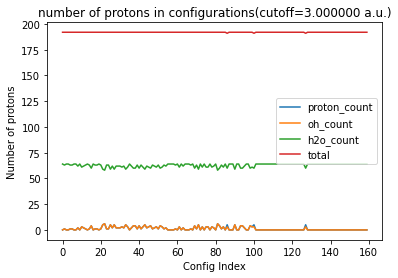

In [30]:
plt.title("number of protons in configurations(cutoff=%f a.u.)" % (cutoff))
plt.xlabel('Config Index')
plt.ylabel('Number of protons')
plt.plot(np.arange(len(protons)),protons)
plt.legend(['proton_count','oh_count','h2o_count','total'])
plt.show()

(array([90., 19., 14., 14., 11., 12.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

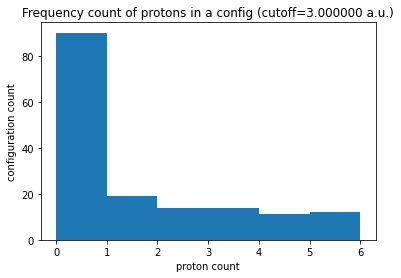

In [31]:
plt.title("Frequency count of protons in a config (cutoff=%f a.u.)" % (cutoff))
plt.xlabel("proton count")
plt.ylabel("configuration count")
pros=np.array([i[0] for i in protons])
plt.hist(pros, bins=np.arange(pros.min(), pros.max()+1))


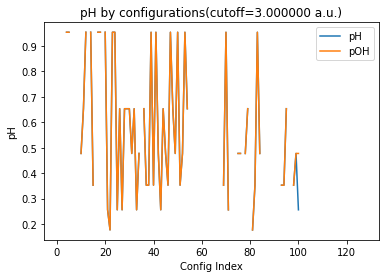

In [32]:
plt.title("pH by configurations(cutoff=%f a.u.)" % (cutoff))
plt.xlabel('Config Index')
plt.ylabel('pH')
plt.plot(np.arange(len(ph)),ph)
plt.legend(['pH','pOH'])
plt.show()

In [33]:
# disassociation const 

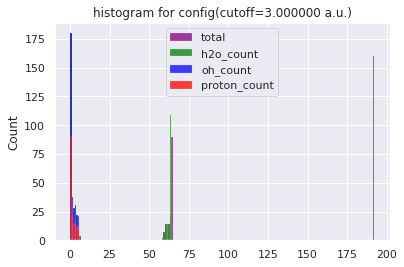

In [34]:
data = protons
sns.set()
for i, color in enumerate(['red', 'blue', 'green', 'purple'][::-1]):
    sns.histplot([di for d in data for di in d[:4-i]], binwidth=1, color=color, stat="count")
plt.legend(['proton_count','oh_count','h2o_count','total'][::-1])
plt.title("histogram for config(cutoff=%f a.u.)" % (cutoff))
plt.show()

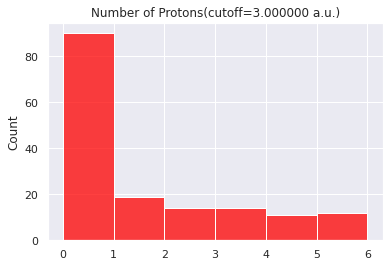

In [35]:
sns.histplot([d[0] for d in data],color='red',binwidth=1)
plt.title("Number of Protons(cutoff=%f a.u.)" % (cutoff))
plt.show()

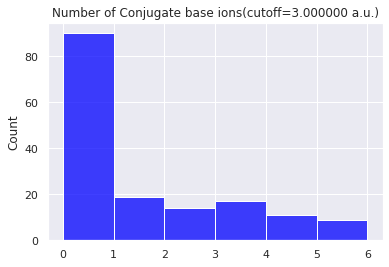

In [36]:
sns.histplot([d[1] for d in data],color='blue',binwidth=1)
plt.title("Number of Conjugate base ions(cutoff=%f a.u.)" % (cutoff))
plt.show()

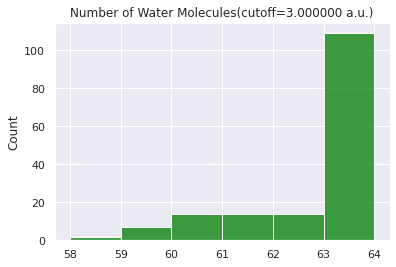

In [37]:
sns.histplot([d[2] for d in data],color='green',binwidth=1)
plt.title("Number of Water Molecules(cutoff=%f a.u.)" % (cutoff))
plt.show()

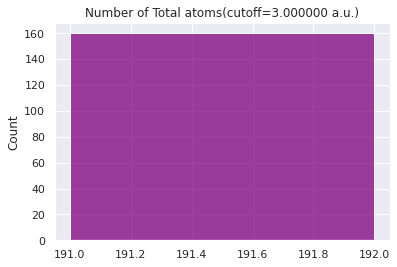

In [38]:
sns.histplot([d[3] for d in data],color='purple',binwidth=1)
plt.title("Number of Total atoms(cutoff=%f a.u.)" % (cutoff))
plt.show()

In [39]:
count =0
for ind,i in enumerate(data):
    if i[3]!=192:
        print(ind,i)
        count+=1
print("count of nascent oxy=",count)

86 (5, 3, 60, 191)
100 (5, 3, 60, 191)
127 (5, 3, 60, 191)
count of nascent oxy= 3


In [40]:
for ind,i in enumerate(config[25].atoms):
    if(i.element=="O" and len(i.hydrogens)==0):
        print(ind,"oxygen=",str(getlen(i.oxygen)),"hydrogens=",len(i.hydrogens),"position=",i.x,i.y,i.z)